In [1]:
library(ggpubr)
library(tidyverse)
library(caret)
library(pROC)
library(ranger)
library(doParallel)

Warning message:
"package 'ggpubr' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.2"Loading required package: magrittr
Warning message:
"package 'tidyverse' was built under R version 3.6.2"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v tibble  2.1.3     v dplyr   0.8.4
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
v purrr   0.3.3     
Warning message:
"package 'tidyr' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::extract()   masks magrittr::extract()
x dplyr::filter()    masks stats::filter()
x purrr::flatten()   masks jsonlite::flatten()
x dplyr::lag()       masks stats::lag()
x purrr::set_names() masks magrittr::set_names()
Warning m

# Introduction
L'objet de l'étude est la **classification des cyberattaques** sur les appareils mobiles sous sytème Android à partir des données qui s'échangent et transitent par le smartphone, recoltées par le moniteur des ressources. Le but étant d'effectuer le traitement adapté pour nettoyer l'appareil sans avoir besoin de la réinitialiser en perdant des données personnelles.

Pour classer des appareils infectées ou non, les données du moniteur de ressources ne permettent pas de le faire puisque le téléphone attaqué arrive à avoir un comportement "normal" (sauf quelques `ransomeware`). L'analyse des logs (texte) permet de déceler les moments anormaux mais ne renseigne pas le type d'infection. Donc pour un log de réseau anormal, on récolte les données du moniteur de ressources. Nous intervenons dans cette deuxième partie.  
Les données proviennent de l'[Université du Nouveau-Brunswick](https://www.unb.ca/cic/datasets/index.html) au Canada.

Dans cette étude, l'appareil est déjà infectée et les attaques ne peuvent pas se superposer (impossibilité d'avoir plus d'une infection).  
En regroupant certaines classes de même nature, dont les variances sont très faibles, on a 4 attaques qui sont indécelables en analysant le comportement de l'appareil de façon générale:

- `adware`, qui affiche des pubs ciblées tout en espionnant de manière illégale les activités de l'appareil.
- `botnet`, qui intègre le téléphone à un réseau d'[appareils zombies](https://fr.wikipedia.org/wiki/Machine_zombie).
- `ransomeware`, qui chiffre l'intégralité des données ou uniquement une partie (le cas ici) et qui se déchiffre après avoir payé une rançon ou en utilisant un décrypteur.
- `sms`, qui installe un vers ou un cheval de Troie pour le transformer en appareil zombie.

Pour être actifs, les appareils communiquent avec les serveurs des cyberattaquants. Nous analyserons les données liées à ces échanges.

In [2]:
data <- read_csv("data/hackerAttack.csv")
data <- data %>% rename_all(make.names)

Parsed with column specification:
cols(
  .default = col_double(),
  `Destination IP` = col_character(),
  Label = col_character()
)
See spec(...) for full column specifications.


# I. Features Engineering
Dans nos données brutes, nous avons 81 variables et 4 000 observations.  
Pour nettoyer nos données, nous devons supprimer les colonnes constantes ou ayant de faible variance (inférieure au premier quartile des variances), transformer certaines variables:

- `Destination IP`, en facteur `IP` en ne gardant que le **Net-ID** (le 1<sup>er</sup> octet si classe A, les 2 premiers sinon)
- `Source Port` et `Destination Port`, en `SPort` et `DPort`, de num à facteur en suivant les types d'attribution de l'[IANA](https://fr.wikipedia.org/wiki/Internet_Assigned_Numbers_Authority)
- `Protocol`, de num à facteur en suivant les [assignements](https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml) de l'IANA
- `Label`, nos variables à expliquer $Y$ en facteur.
- Les variables quantitatives, standardisées.

In [3]:
ip_split <- function(ip){
    #' Renvoie le Net-ID d'une adresse IP
    octets <- str_split(ip, "\\.")[[1]]
    if (as.numeric(octets[1]) <= 127) {
        netID <- octets[1]
    } else {
        netID <- paste(octets[1], octets[2], sep = ".")
    }
    
    return(netID)
}

In [4]:
data %>% 
select_if(is.numeric) %>% 
summarise_all(var) %>% 
gather() %>%
select(value) %>%
as.matrix() %>%
quantile(0.25) -> q1

Transformation des IPs.

In [5]:
data <- data %>% 
rename(IP = 'Destination.IP') %>% 
rowwise() %>% # vectorise la fonction ip_split
mutate(IP = ip_split(IP)) %>% 
as_tibble() # supprime rowwise_df

Les autres transformations

In [6]:
data <- data %>% 
rename(
    SPort = 'Source.Port',
    DPort = 'Destination.Port',
) %>% 
mutate(
    DPort = case_when(
        DPort == 53 ~ "DNS",
        DPort == 80 ~ "HTTP",
        DPort == 443 ~ "HTTPS",
        DPort %in% c(1024:5000, 49152:65535) ~ "Microsoft RPC",
        DPort %in% 60000:61000 ~ "Mosh",
        TRUE ~ "Private"
    ),
    SPort = case_when(
        SPort == 80 ~ "HTTP",
        SPort == 443 ~ "HTTPS",
        SPort %in% c(1024:5000, 49152:65535) ~ "Microsoft RPC",
        SPort %in% 60000:61000 ~ "Mosh",
        TRUE ~ "Private"
    )
) %>% 
mutate_at(
    c('SPort', 'DPort', 'IP', 'Protocol', 'Label'),
    funs(factor)
) %>% 
select(
    1:4, # Facteurs
    colnames(select_if(., function(col) is.numeric(col) && var(col) >= q1)), # Variances faibles
    ncol(.) # Label
) %>% 
mutate_if(
    is.numeric,
    scale
)

Warning message:
"funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session."

In [7]:
dim_quant <- data %>% select_if(is.numeric) %>% ncol()
dim_IP <- length(unique(data$IP))
dim_SPort <- length(unique(data$SPort))
dim_DPort <- length(unique(data$DPort))
dim_Protocol <- length(unique(data$Protocol))
dim_X <- dim_quant + dim_IP-1 + dim_SPort-1 + dim_DPort-1 + dim_Protocol-1

Nous obtenons une dimension de `r dim(data)` après nettoyage.

Un total de `r dim_X` variables explicatives:

- `r dim_quant` variables quantitatives.
- `r dim_IP` modalités de IP.
- `r dim_SPort` modalités de SPort
- `r dim_DPort` modalités de DPort
- `r dim_Protocol` modalités de Protocol.

On ne peut pas utiliser l'ACP pour réduire les dimensions puisque les variables ne sont pas linéaires. La stratégie sera d'éliminer les variables qui ne sont pas importantes pour les modèles de classifications.

# II. Statistique descriptive
Visualisons dans cette partie la distribution de nos variables pour en tirer des informations qui peuvent aider à la classification.

## 1. Variables qualitatives

### Les Ports et les attaques
En visualisant la répartition de l'utilisation des ports d'entrée et de sortie pour chaque infection, on peut voir:

- De manière générale, les attaquants récoltent les données ou les réponses de leurs requêtes en ouvrant des ports privés ou en utilisant l'exploit Microsoft RPC. Ils les recoivent via des requêtes HTTP et HTTPS sur leurs serveurs distants. L'étude des IP permettra d'identifier les serveurs ou les 1<sup>er</sup> noeuds s'il s'agit d'un [réseau TOR](https://fr.wikipedia.org/wiki/Tor_(r%C3%A9seau)).
- Le port DNS n'est pas utilisé en source et très peu pour recevoir. Les attaques par DNS les plus courants sont des [DDoS](https://fr.wikipedia.org/wiki/Attaque_par_d%C3%A9ni_de_service) contre de grandes structures ou du [Phishing](https://fr.wikipedia.org/wiki/Hame%C3%A7onnage) contre des personnes ciblées comme dans notre cas. On souligne directement que le `botnet` n'utilise pas le DNS puisqu'il n'a pas besoin d'usurper un site pour infecter.
- Près de 80% de la recéption des requêtes des `ransomeware` et 65% des `botnet` passent par le port 443, HTTPS. Il s'agit aussi des deux infections qui ont obligatoirement besoin d'un [back door](https://fr.wikipedia.org/wiki/Porte_d%C3%A9rob%C3%A9e) pour que l'attaquant garde le plus longtemps possible le contrôle de l'appareil.

Warning message:
"attributes are not identical across measure variables;
they will be dropped"

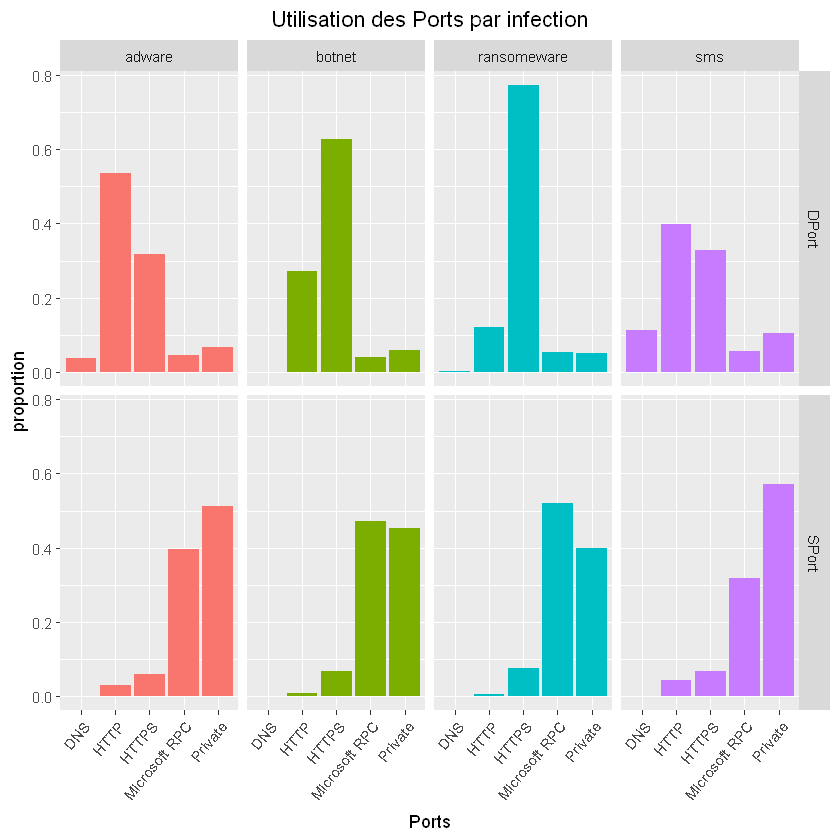

In [8]:
data %>%
select(SPort, DPort, Label) %>%
gather("Entry", "Port", -Label) %>% ggplot() + 
aes(x = Port, y = ..prop.., group = 1, fill = Label) +
geom_bar() + guides(fill = F) + 
facet_grid(cols = vars(Label), rows = vars(Entry)) +
labs(title = "Utilisation des Ports par infection", x = "Ports", y = "proportion") +
theme(
    axis.text.x = element_text(angle = 50, hjust = 1),
    plot.title = element_text(hjust = 0.5)
)

### Les IPs et les protocoles
L'analyse des NetID des adresses IP permet d'obtenir des informations sur le comportement des infections.  
En analysant les 2 NetID les plus utilisés par infection, on s'aperçoit que:

- Le 172.217 (classe B) est le plus utilisé, sauf pour les `sms` qui le placent en 2<sup>e</sup>.
- Le deuxième le plus fréquent est de classe A, le 10 pour toutes sauf pour les `ransomeware` avec le 119.

L'analyse des protocoles (*ici utilisés pour la réception DPort*) y ajoute plus d'informations:

- On retrouve les 2 mêmes NetID les plus fréquents pour le protocol 6 (TCP) et 17 (UDP)
- Le protocol 0 (HOPOPT) utilise deux NetID de classe A, dont le 8 qui représente 93.8% du traffic
- Le 10 représente 87.5% du traffic du protocol 17 (UDP), moins sécurisé que le TCP.
- Au moins 95% des traffics utilisent le protocol 6 (TCP) pour toutes infections sauf `sms`, qui est le plus grand utilisateur du protocol 17 (UDP).

In [9]:
ip_label <- data %>% 
group_by(Label, IP) %>% 
summarise(proportion = n()) %>%
mutate(proportion = proportion*100 / sum(proportion)) %>% 
top_n(2, proportion) %>% 
ggplot() + aes(x = IP, y = proportion, fill = IP) +
geom_bar(stat="identity") + facet_grid(Label~.) +
guides(fill = F) + xlab("NetID")

ip_protocol <- data %>% 
group_by(Protocol, IP) %>% 
summarise(proportion = n()) %>%
mutate(proportion = proportion*100 / sum(proportion)) %>% 
top_n(2, proportion) %>% 
ggplot() + aes(x = IP, y = proportion, fill = IP) +
geom_bar(stat="identity") + facet_grid(Protocol~.) +
guides(fill = F) + xlab("NetID") +
scale_fill_manual(values = c("#f39c12", "#f8766d", "#619cff", "#8e44ad"))

Label,0,6,17
adware,0.6,95.4,4.0
botnet,0.9,98.9,0.2
ransomeware,0.9,98.9,0.2
sms,1.9,84.7,13.4


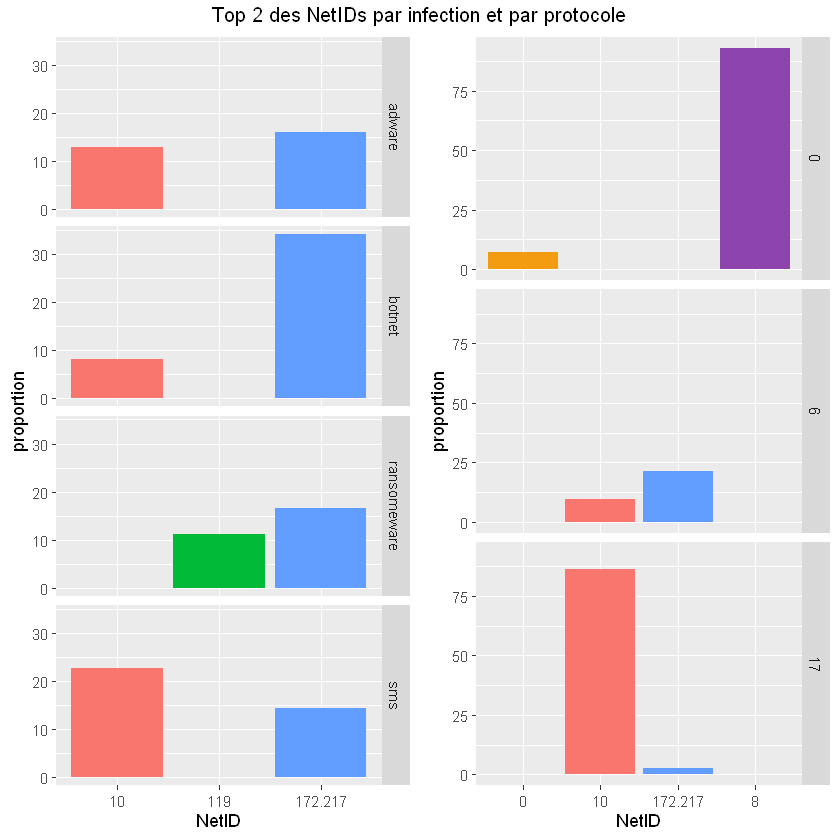

In [10]:
data %>% 
group_by(Label, Protocol) %>% 
summarise(proportion = n()) %>%
mutate(proportion = proportion*100 / sum(proportion)) %>% 
spread(Protocol, proportion)
ggarrange(
    ip_label, ip_protocol,
    ncol = 2, nrow = 1
) %>% 
annotate_figure(top = "Top 2 des NetIDs par infection et par protocole")

### En résumé
Avec l'analyse des 4 variables qualitatives, il est déjà possible de dresser les profils des infections:

- `sms` utilise moins de chiffrement: plutôt HTTP que HTTPS, avec l'utilisation du protocol 17 (UDP) qui reçoit beaucoup sur le NetID 10. Il s'agit d'une attaque courte. La variable `Flow Duration` devrait avoir une valeur faible et les `Packets` grandes.
- `ransomeware` est la plus chiffrée et reçoit sur le NetID 119 pour la classe A. Il s'agit de l'attaque communiquer le plus avec le serveur tant qu'elle n'est pas résolue. Les variables de types `Active` devrait prendre de grandes valeurs.
- `botnet` et `adware` se distinguent uniquement par l'utilisation des chiffrements à la réception (`botnet` est plus HTTP). Les variables quantitatives ne permettent pas plus de les discriminer.

## 2. Variables quantitatives
Rappelons que les données ont été standardisées.

### Longueur de paquet
La variable `Min Packet Length` est celle qui est la plus corrélée aux labels. Elle représente la taille minimale du packet en prenant en compte l'en-tête.  
Comme attendu, la densité est plus répartie pour `sms`. La variable étant plus concentrée autour de la moyenne pour `ransomeware` et `botnet`.

Warning message:
"Removed 8 rows containing non-finite values (stat_density)."

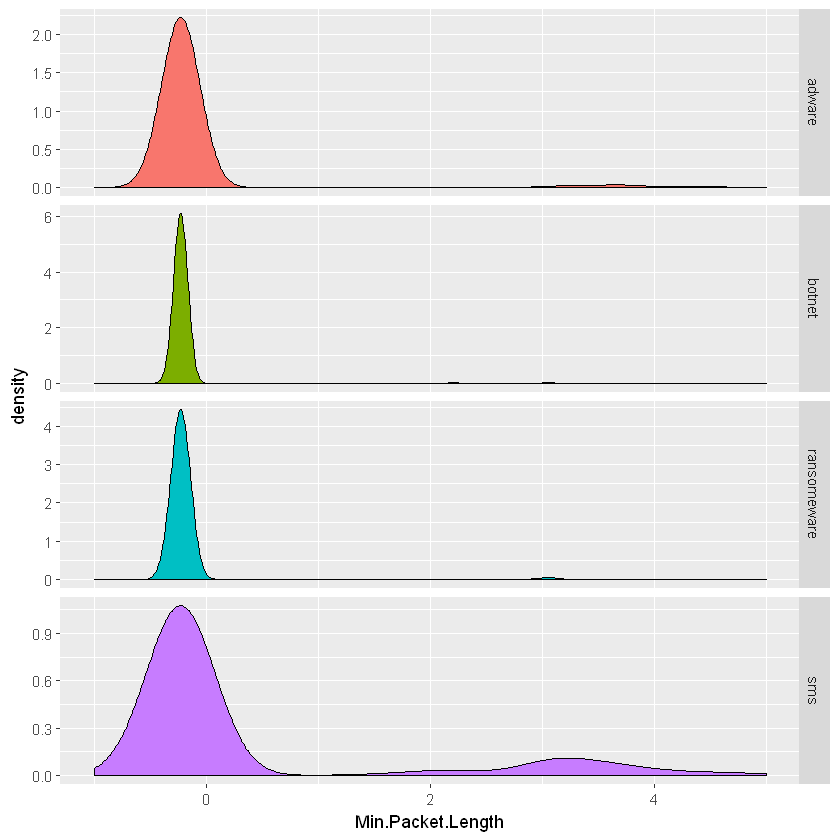

In [11]:
ggplot(data) + aes(x = `Min.Packet.Length`, fill = Label) +
geom_density() + facet_grid(Label~., scales = "free_y") +
xlim(range(-1,5)) + guides(fill = F)

### Durée de débit
La visualisation de `Flow Duration` permet de visualiser le temps de connexion entre le serveur et l'appareil.  
L'infection par `sms` étant rapide et n'ayant pas systématiquement besoin d'un backdoor, elle se distingue facilement par une durée de débit faible par rapport aux autres infections.  
Cela confirme l'analyse sur les protocols où le chiffrement n'est pas nécessaire.

Warning message:
"Removed 1263 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 1263 rows containing non-finite values (stat_boxplot)."

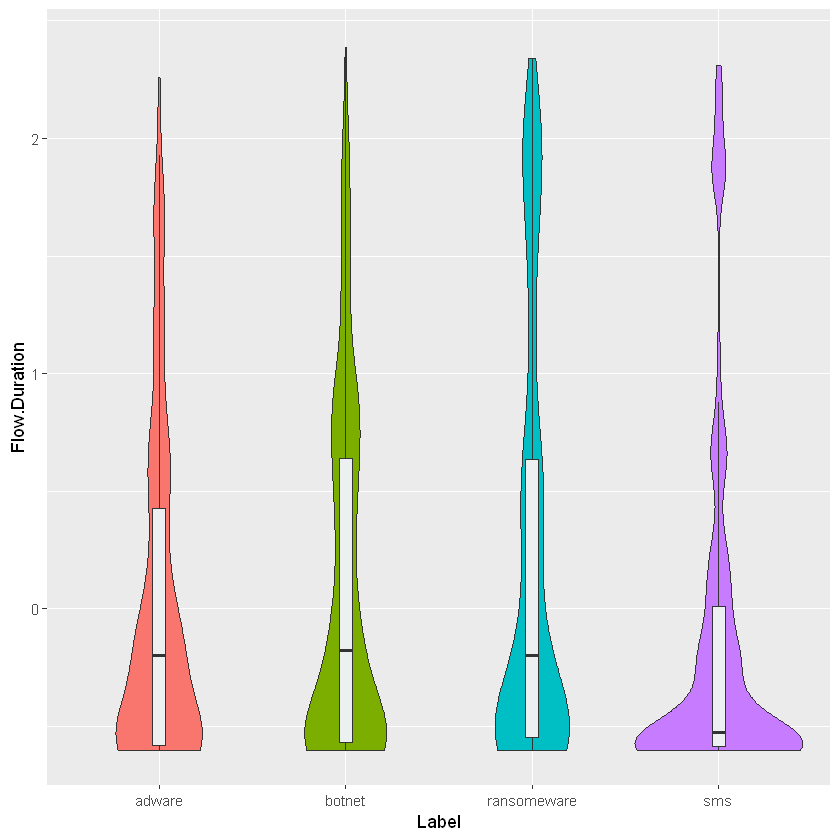

In [12]:
ggplot(data) + aes(y = `Flow.Duration`, x = Label, fill = Label) +
geom_violin() + ylim(range(-0.6:2.6)) + guides(fill = F) +
geom_boxplot(width = 0.07, fill = "#ecf0f1", outlier.size = -1)

### Durée entre 2 paquets d'un débit
La variable `Flow IAT Mean` représente la vitesse moyenne d'envoi de paquets, entre autres la durée entre l'envoi de 2 paquets dans un seul débit. Un Flow IAT faible est un débit plus rapide.  
L'infection `sms` doit envoyer dans une durée faible le maximum d'informations, tandis que pour les `botnet`, pour lesquelles les machines zombies sont souvent utilisées pour attaquer en DDoS, l'attaquant envoie une instruction et doit attendre l'exécution de celle-ci avant de déconnecter, d'où une vitesse faible.

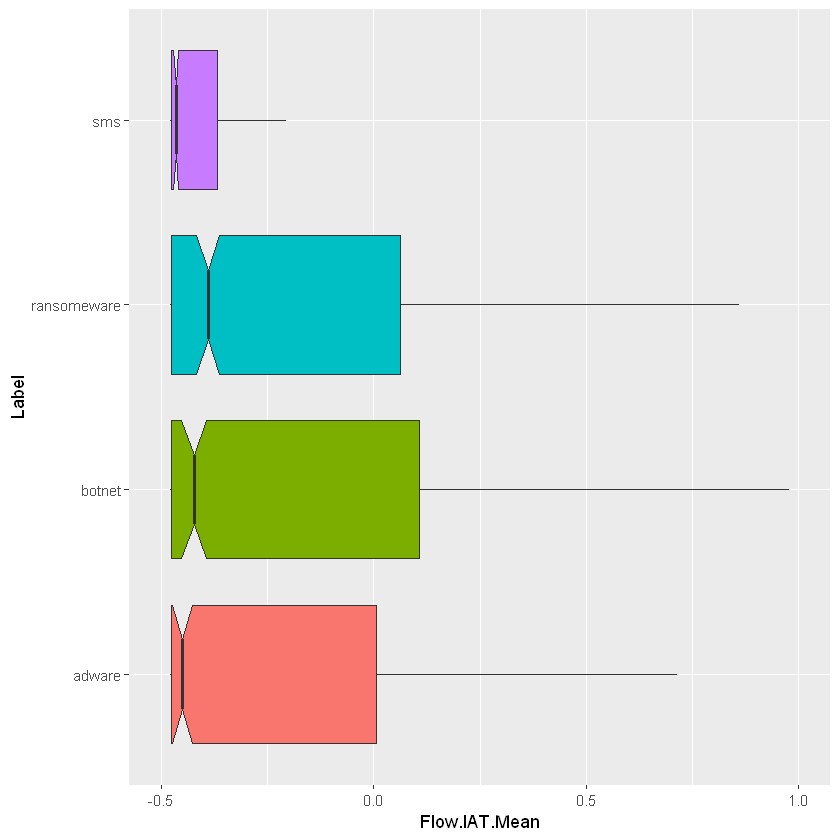

In [13]:
ggplot(data) + 
aes(y = `Flow.IAT.Mean`, x = Label, fill = Label) +
geom_boxplot(notch=T, outlier.size = -1) +
coord_flip(ylim=c(-0.5, 1)) +
guides(fill = F)

# III. Benchmark et optimisation des modèles

Dans la suite, nous allons comparer 4 algorithmes de classifications :

- Les [KNN](#1.-K-plus-proches-voisins), faciles à mettre en oeuvre,
- Les [forêts aléatoires](#2.-For%C3%AAts-al%C3%A9atoires), classifieurs les plus efficaces "out-of-the-box",
- Le [logitboost](#3.-Logit-Boost), la version stochastique d'Adaboost grâce à la régression logistique,
- [Stochastic gradient boosting](#4.-Gradient-boosting), qui a montré son efficacité dans les challenges.

Nos données n'étant pas linéaires, les analyses discriminantes de type LDA ou QDA sont peu pertinantes.

### Stratégie
La stratégie sera de créer 4 folds dont 10% pour le test final et 3 x 30% pour les validations croisées en entraînement. Chacun des 4 algorithmes s'entraînera **sur les mêmes folds en validation croisée** (*avec les tests*), pour que la comparaison ait un sens, et sera testé en plus sur le 4<sup>e</sup> fold pour pouvoir tester sur des données pas encore vues et tracer les courbes ROC.  
L'optimisation des paramètres se fera par Grid Search en 2 temps, une approche naïve et une optimisation, en utilisant comme métriques l'**AUC** et l'**Accuracy**. L'évaluation et la sélection de modèle se fera en fonction des deux mêmes métriques.  
Pour se faire, 4 fonctions ont été codées (*ne figurent pas ici mais présentes dans le markdown associé*):

- `split_set( )`: divise nos données de manière aléatoire en partitions fixes train et test, en 90% - 10%
- `plotmetrics( )`: représente l'évolution de l'AUC et de l'Accuracy en fonction de l'évolution d'un paramètre à optimiser
- `confmatrix( )`: repésente la matrice de confusion
- `multiroc( )`: représente la courbe ROC d'un modèle pour chaque label en One-vs-rest

L'objet `tune_control` fixe les folds pour la validation croisée pour permettre l'évaluation avec nos métriques et la comparaison de nos modèles

In [14]:
split_set <- function(data, trainSize = 0.9){
    #' Divise nos données en partitions train et test
    
    set.seed(2020)
    part <- createDataPartition(data$Label, p = trainSize)
    train_set <- data %>% slice(part$Resample1)
    test_set <- data %>% slice(-part$Resample1)
    
    return(list(train_set, test_set))
}

In [15]:
plotmetrics <- function(train_obj, parameter){
    #' Renvoie un ggplot de l'évolution d'Accuracy et AUC
    #' train_obj: objet de type train de caret
    #' param: paramètre évalué
    
    train_obj <- train_obj$results %>% select(!!parameter, AUC, Accuracy)
    AUC_limits <- c(min(train_obj$AUC), max(train_obj$AUC))
    Accuracy_limits <- c(min(train_obj$Accuracy), max(train_obj$Accuracy))
    train_obj$Accuracy <- train_obj$Accuracy * (AUC_limits[2]/Accuracy_limits[2])
    limit <- c(min(train_obj[,2:3]), max(train_obj[,2:3]))
    maxAUC <- filter(train_obj, AUC == max(AUC))
    maxAccuracy <- filter(train_obj, Accuracy == max(Accuracy))

    plot <- train_obj %>% 
    ggplot() + aes_string(x = parameter) + 
    geom_line(aes(y = AUC), color = "#38ada9") +  
    geom_point(aes(y = AUC), color = "#38ada9") +
    geom_line(aes(y = Accuracy), color = "#e55039") +
    geom_point(aes(y = Accuracy), color = "#e55039") +
    geom_point(data = maxAUC, aes_string(x = parameter, y = "AUC"), color = "#38ada9", shape = 5, size = 3) +
    geom_point(data = maxAccuracy, aes_string(x = parameter, y = "Accuracy"), color = "#e55039", shape = 0, size = 3) +
    scale_y_continuous(
        limits = limit,
        sec.axis = sec_axis(~ . *Accuracy_limits[2]/AUC_limits[2],
                            name = "Accuracy")) +
    theme(
        plot.title = element_text(hjust = 0.5),
        axis.title.y.left = element_text(color = "#38ada9"),
        axis.text.y.left = element_text(color = "#38ada9"),
        axis.title.y.right = element_text(color = "#e55039"),
        axis.text.y.right = element_text(color = "#e55039"),

    )
    
    return(plot)
}

In [16]:
confmatrix <- function(test, pred){
    #' Renvoie un ggplot de matrice de confusion
    #' test, pred: vecteurs de même taille
    
    plot <- confusionMatrix(test, pred)$table %>% 
    as_tibble() %>%
    ggplot() +
    aes(x = Reference, y = reorder(Prediction, desc(Prediction)), fill = n) + 
    geom_tile() +
    geom_text(aes(label = paste(round(n, 2), '%')), color = "white", size = 5) +
    labs(y = "Prediction") + guides(fill = F) +
    scale_fill_gradient(low = "#c0392b", high = "#27ae60") +
    theme(plot.title = element_text(hjust = 0.5))
    
    return(plot)
}

In [17]:
multiroc <- function(Y, Y_pred){
    #' Renvoie les courbes ROC de chaque classe
    
    predicted <- tibble(
        Y = as.character(Y),
        Y_pred = as.character(Y_pred)
    )

    roclist <- vector(mode = "list")

    for (label in unique(predicted$Y)){
        one_rest <- predicted %>% 
        mutate(
            Y = if_else(
                Y == label,
                1, 0
            ),
            Y_pred = if_else(
                Y_pred == label,
                1, 0
            )
        )

        roclist[[label]] <- roc(one_rest$Y, one_rest$Y_pred)
    }

    plot <- roclist %>% ggroc(aes = "color", size = 1, legacy.axes = TRUE) +
    labs(color = "Labels") + theme(plot.title = element_text(hjust = 0.5))
    
    return(plot)
}


In [19]:
train_set <- split_set(data)[[1]]
test_set <- split_set(data)[[2]]

tune_control <- trainControl(
  method = "cv", 
  number = 3,
  index = createMultiFolds(train_set$Label, k = 3, times = 1),
  classProbs = TRUE,
  summaryFunction = multiClassSummary
)

## 1. K plus proches voisins
L'algorithme des K plus proches voisins se base sur la distance entre les individus et ne fait aucune supposition préalable des données.  
Sa règle est la suivante:  
soient $k \leq n$, $x$ à classer et $\text{kkpv}(x) = \{i: X_i\, \text{parmi les}\, k \,\text{plus proches voisins de}\, x \,\text{dans}\, \{X_1, .. X_n\} \}$, la règle de classification est
$$\hat{g}(x) = \underset{k \in Y}{\operatorname{argmax}}  \underset{i \in kkpv(x)}{\operatorname{\sum}} 1_{Y_i = k} $$

### Approche naïve
Dans l'algorithme que nous allons entraîner, le paramètre à optimiser est $k$.  
Nous allons effectuer une recherche sur les 3 à 170 voisins par pas de 6. 

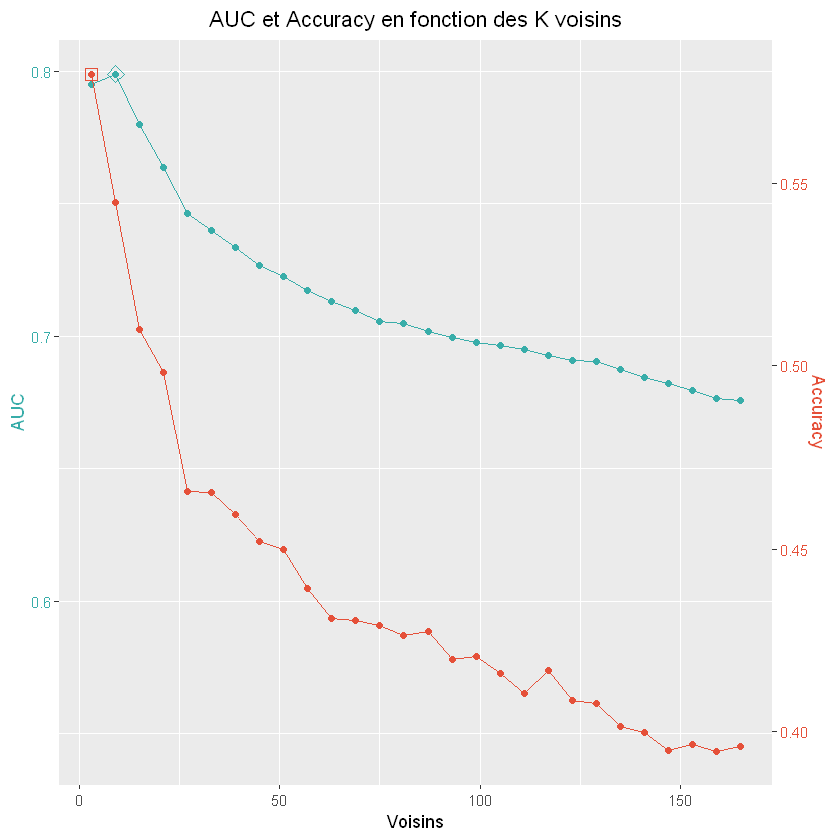

In [22]:
knn_tune_naive <- data.frame(
    k = seq(3, 170, by = 6)
)

cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

knn_naive_cv <- train(
    Label ~ .,
    data = train_set,
    method = "knn",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = knn_tune_naive,
)

on.exit(stopCluster(cl))

plotmetrics(knn_naive_cv, "k") +
labs(title = "AUC et Accuracy en fonction des K voisins", x = "Voisins")

Sur la plage qu'on a testé, les meilleurs $k$ se situe entre 3 et 15, 3 pour Accuracy et 9 pour l'AUC.  
L'optimisation se fera donc sur cette nouvelle plage.

### Optimisation

Il n'y a pas de pre-traitement à faire en plus pour l'optimisation. Toutefois, pour l'uniformité des procédures de comparaison des modèles, affectons de nouveaux (*les mêmes*) sets. Ceci est utile pour la description du Pipeline si ce modèle sera choisi.

In [23]:
train_knn <- split_set(data)[[1]]
test_knn <- split_set(data)[[2]]

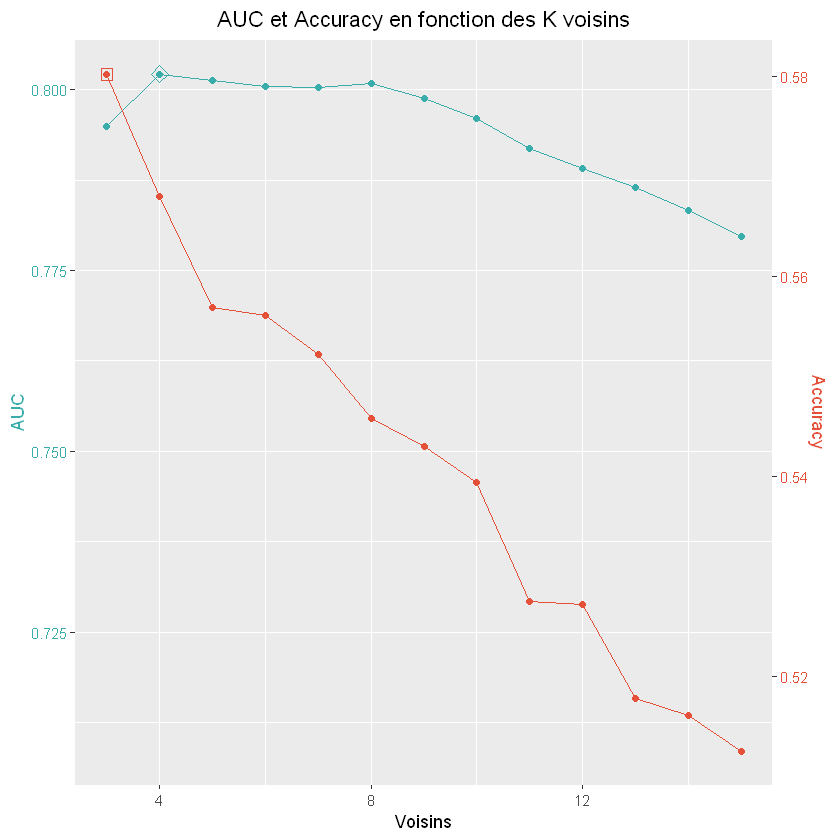

In [26]:
knn_tune <- data.frame(
    k = seq(3, 15)
)

cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

knn_cv <- train(
    Label ~ .,
    data = train_knn,
    method = "knn",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = knn_tune,
)

on.exit(stopCluster(cl))

plotmetrics(knn_cv, "k") +
labs(title = "AUC et Accuracy en fonction des K voisins", x = "Voisins")

In [27]:
model_knn <- knn_cv$finalModel
pred_knn <- predict(knn_cv, newdata = test_knn)

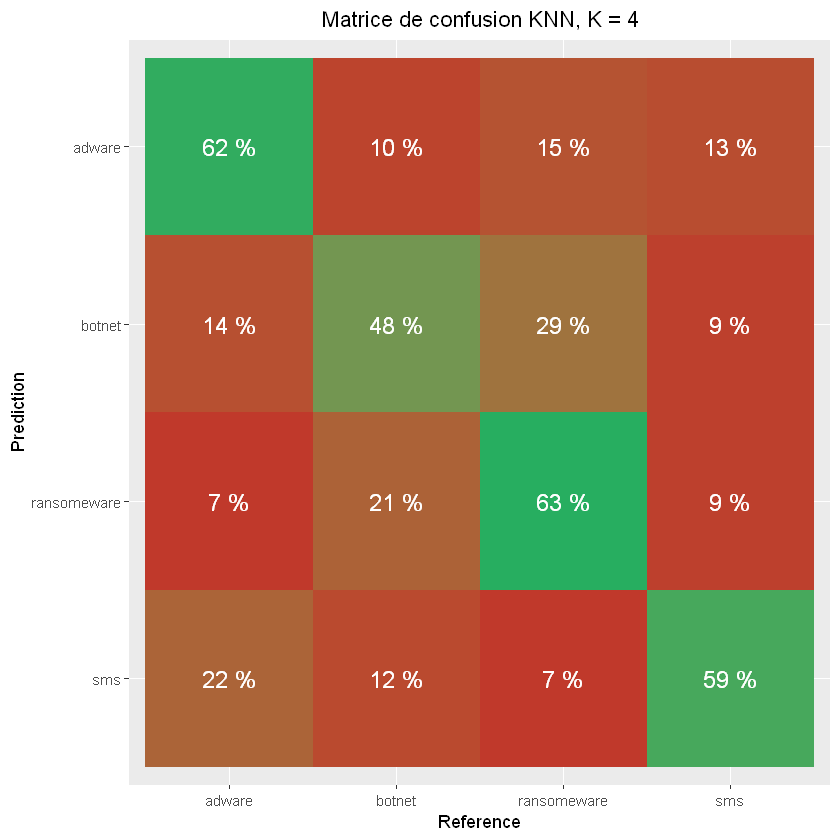

In [28]:
confmatrix(test_knn$Label, pred_knn) +
labs(title = "Matrice de confusion KNN, K = 4")

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


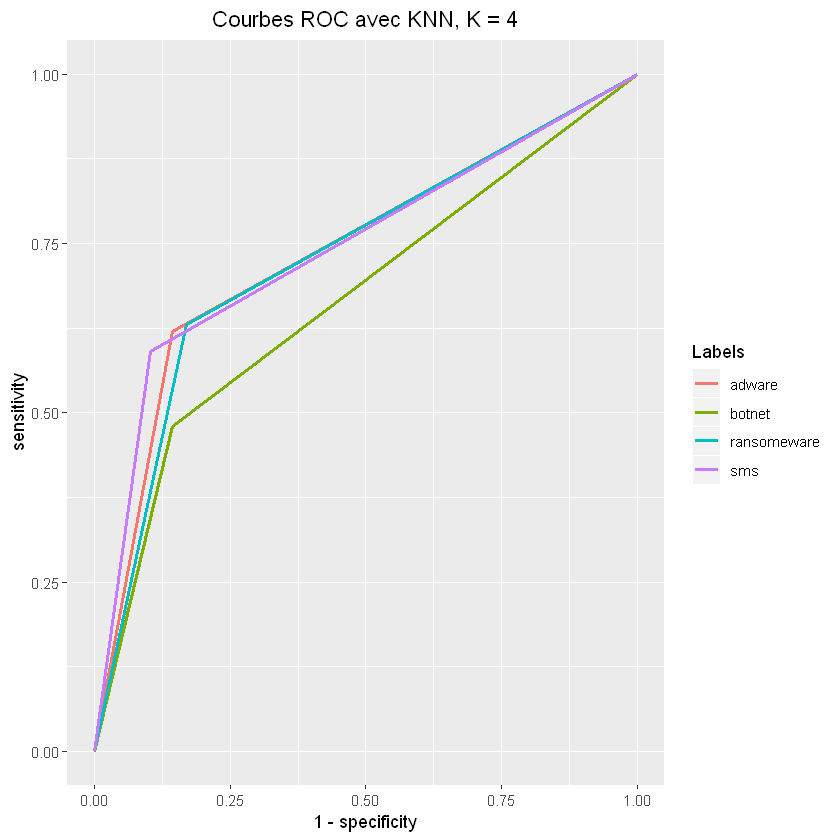

In [29]:
multiroc(test_knn$Label, pred_knn) +
labs(title = "Courbes ROC avec KNN, K = 4")

In [30]:
result <- knn_cv$results %>% 
filter(k == 4)  %>%
mutate(Model = "KNN") %>% 
select(Model, AUC, Accuracy)

## 2. Forêts aléatoires

### Approche naïve

In [31]:
rf_tune_naive <- data.frame(
    mtry = dim_X,
    splitrule = "gini",
    min.node.size = 1
)

In [32]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

rf_naive_cv <- train(
    Label ~ .,
    data = train_set,
    method = "ranger",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = rf_tune_naive,
    importance = 'impurity_corrected'
)

on.exit(stopCluster(cl))

Selecting by importance


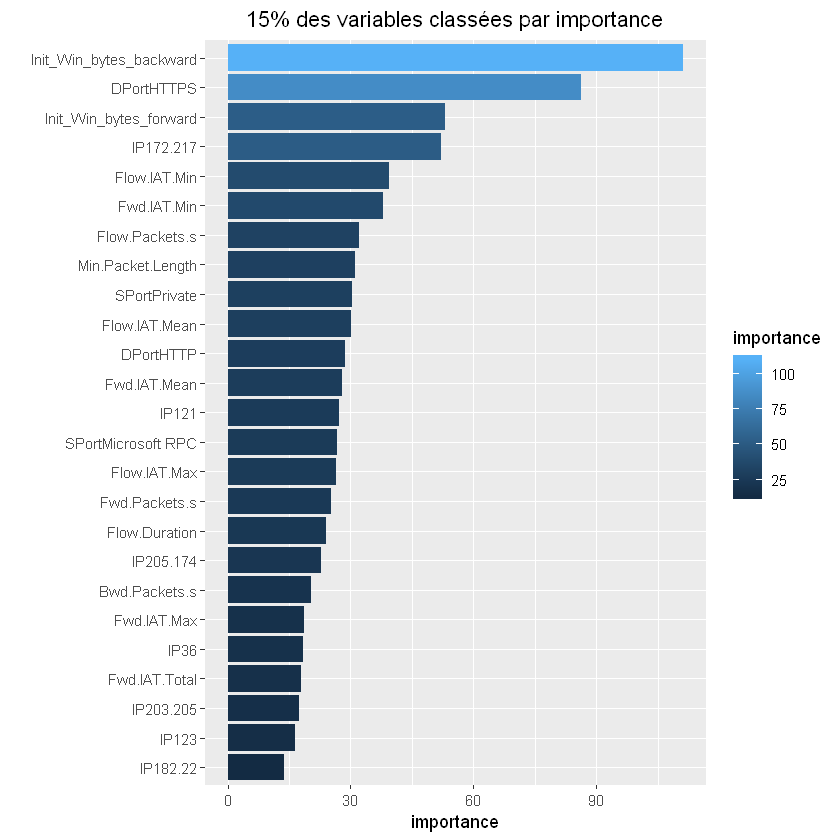

In [33]:
rf_naive_vars <- rf_naive_cv$finalModel$variable.importance
rf_naive_vars <- tibble(variable = names(rf_naive_vars), importance = rf_naive_vars) %>% 
    arrange(importance) %>% mutate(variable = factor(variable, levels = variable)) %>% 
    top_frac(0.15)

ggplot(rf_naive_vars) + coord_flip() + aes(x = variable, y = importance, fill = importance) + geom_bar(stat = "identity") + 
    labs(title = "15% des variables classées par importance", x = "") +
    theme(plot.title = element_text(hjust = 0.5))

### Optimisation

In [34]:
data_rf <- data %>% 
select(
    Label, SPort, DPort, IP,
    any_of(tail(rf_naive_vars, 18)$variable)
) %>% 
mutate(
    IP = factor(if_else(
        IP %in% c("172.217", "121", "205.174"),
        as.character(IP), "OtherIP"
    )),
    SPort = factor(if_else(
        SPort %in% c("Private", "Microsoft RPC"),
        as.character(SPort), "OtherSPort"
    )),
    DPort = factor(if_else(
        DPort %in% c("HTTP", "HTTPS"),
        as.character(DPort), "OtherDPort"
    ))
)

In [35]:
dim_quant_rf <- data_rf %>% select_if(is.numeric) %>% ncol()
dim_IP_rf <- length(unique(data_rf$IP))
dim_SPort_rf <- length(unique(data_rf$SPort))
dim_DPort_rf <- length(unique(data_rf$DPort))
dim_X_rf <- dim_quant_rf + dim_IP_rf-1 + dim_SPort_rf-1 + dim_DPort_rf-1

In [36]:
train_rf <- split_set(data_rf)[[1]]
test_rf <- split_set(data_rf)[[2]]

In [37]:
rf_tune <- data.frame(
    mtry = seq(2, 17),
    splitrule = rep("gini", 16),
    min.node.size = rep(1, 16)
)

In [38]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

rf_cv <- train(
    Label ~ .,
    data = train_rf,
    method = "ranger",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = rf_tune
)

on.exit(stopCluster(cl))

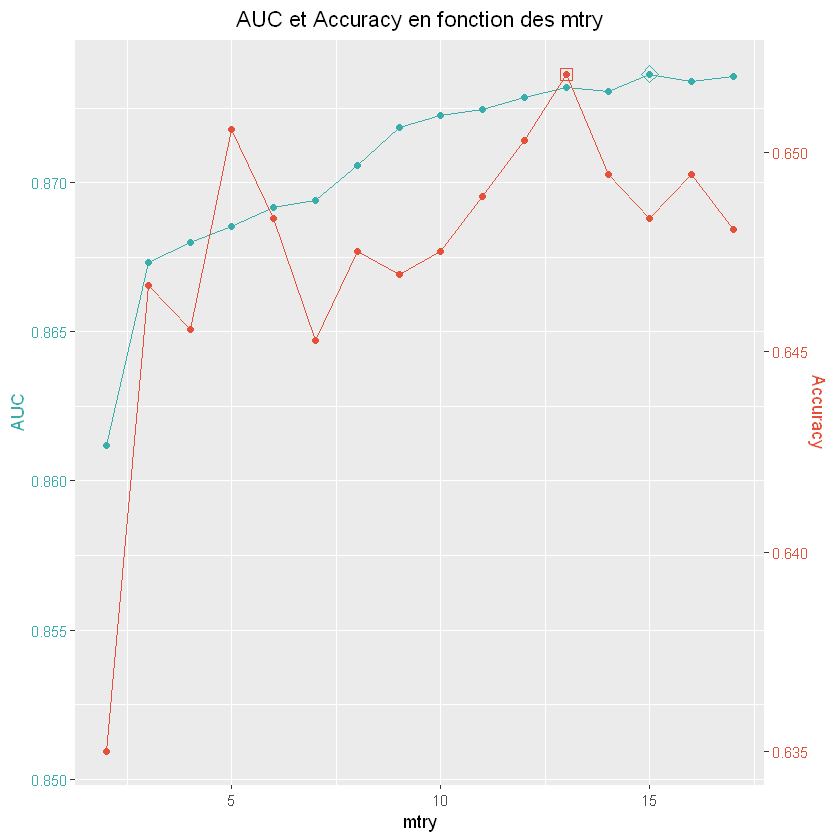

In [39]:
plotmetrics(rf_cv, "mtry") +
labs(title = "AUC et Accuracy en fonction des mtry")

In [40]:
model_rf <- ranger(Label~., data = train_rf, mtry = 13, splitrule = "gini", min.node.size = 1)
pred_rf <- predict(model_rf, data = test_rf)$prediction

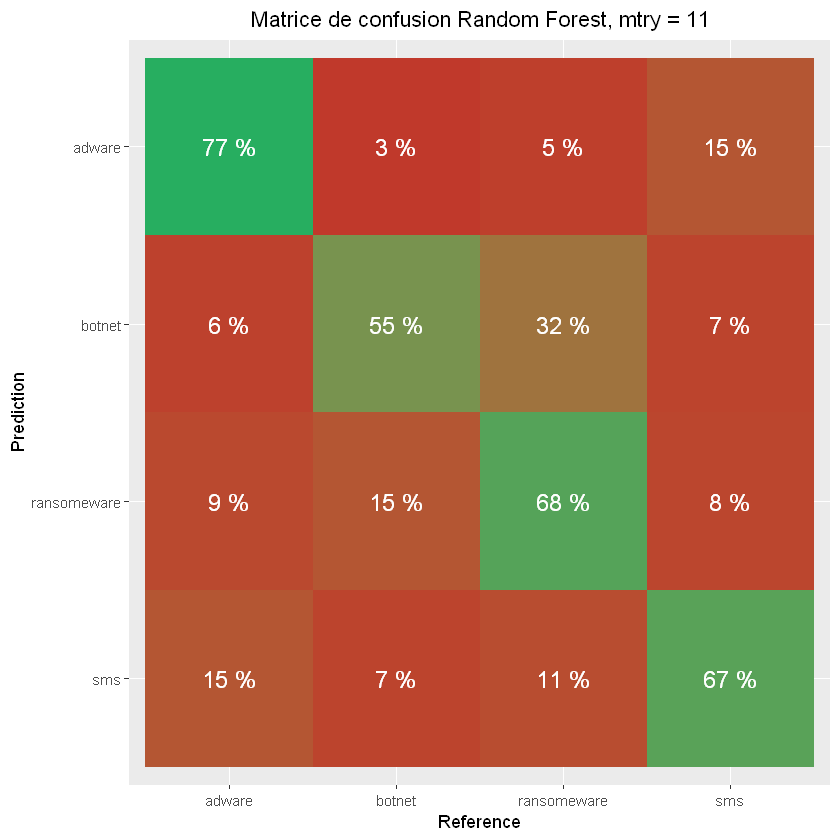

In [41]:
confmatrix(test_rf$Label, pred_rf) +
labs(title = "Matrice de confusion Random Forest, mtry = 11")

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


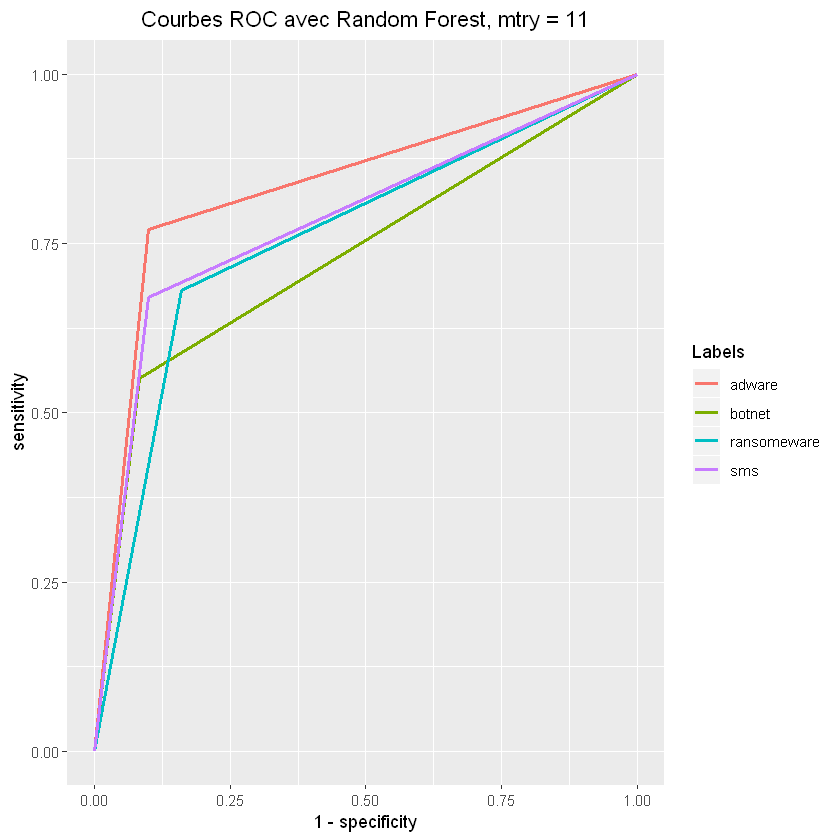

In [42]:
multiroc(test_rf$Label, pred_rf) +
labs(title = "Courbes ROC avec Random Forest, mtry = 11")

In [43]:
result <- result %>%
bind_rows(
    (rf_cv$results %>% 
     filter(mtry == 11)  %>%
     mutate(Model = "RF") %>% 
     select(Model, AUC, Accuracy)
    )
)

## 3. Logit Boost

### Approche Naïve

In [44]:
lgb_tune_naive <- data.frame(
    nIter = seq(1, 171, by =  10)
)

In [45]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

lgb_cv_naive <- train(
    Label ~ .,
    data = train_set,
    method = "LogitBoost",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = lgb_tune_naive
)

on.exit(stopCluster(cl))

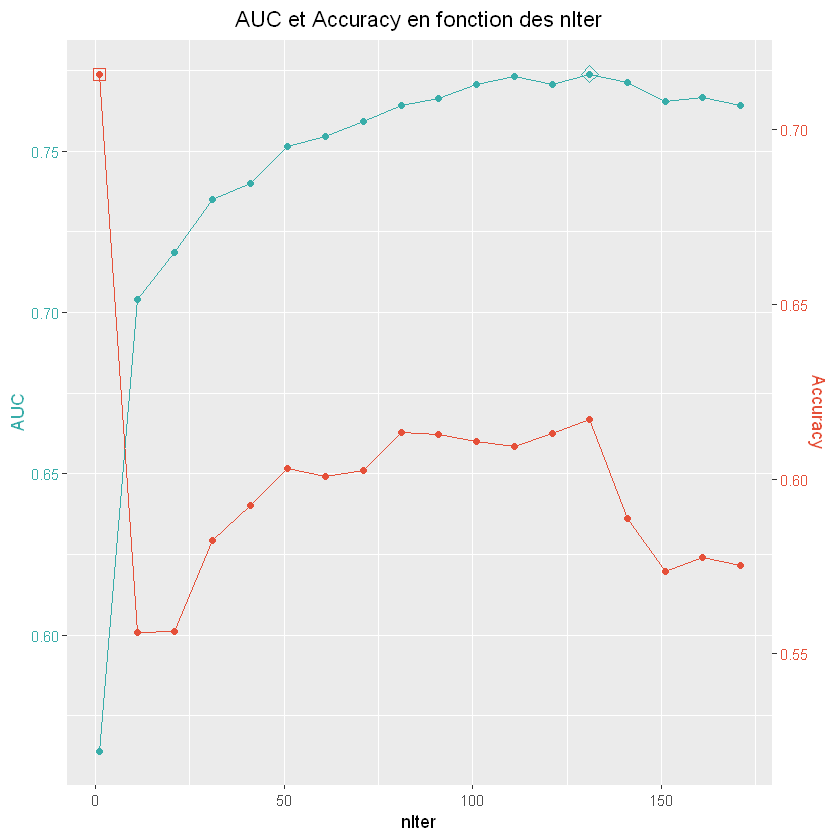

In [46]:
plotmetrics(lgb_cv_naive, "nIter") +
labs(title = "AUC et Accuracy en fonction des nIter")

Entre 120 et 140

### Optimisation

In [47]:
train_lgb <- split_set(data)[[1]]
test_lgb <- split_set(data)[[2]]

In [48]:
lgb_tune <- data.frame(
    nIter = seq(119, 141, by = 2)
)

In [49]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

lgb_cv <- train(
    Label ~ .,
    data = train_lgb,
    method = "LogitBoost",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = lgb_tune
)

on.exit(stopCluster(cl))

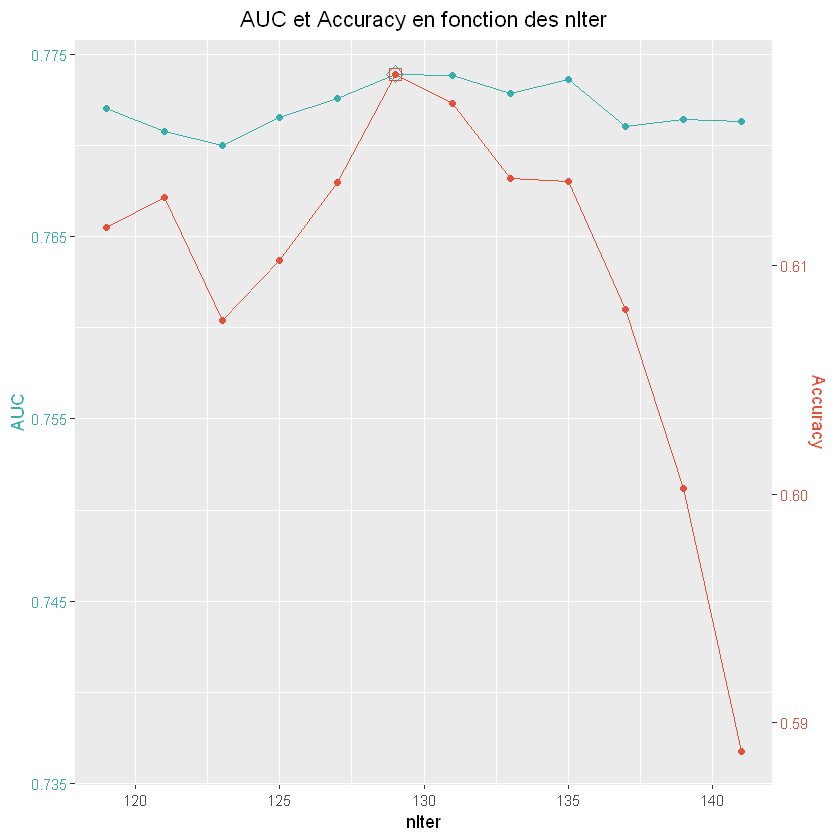

In [50]:
plotmetrics(lgb_cv, "nIter") +
labs(title = "AUC et Accuracy en fonction des nIter")

In [51]:
model_lgb <- lgb_cv$finalModel
pred_lgb <- predict(lgb_cv, newdata = test_lgb)

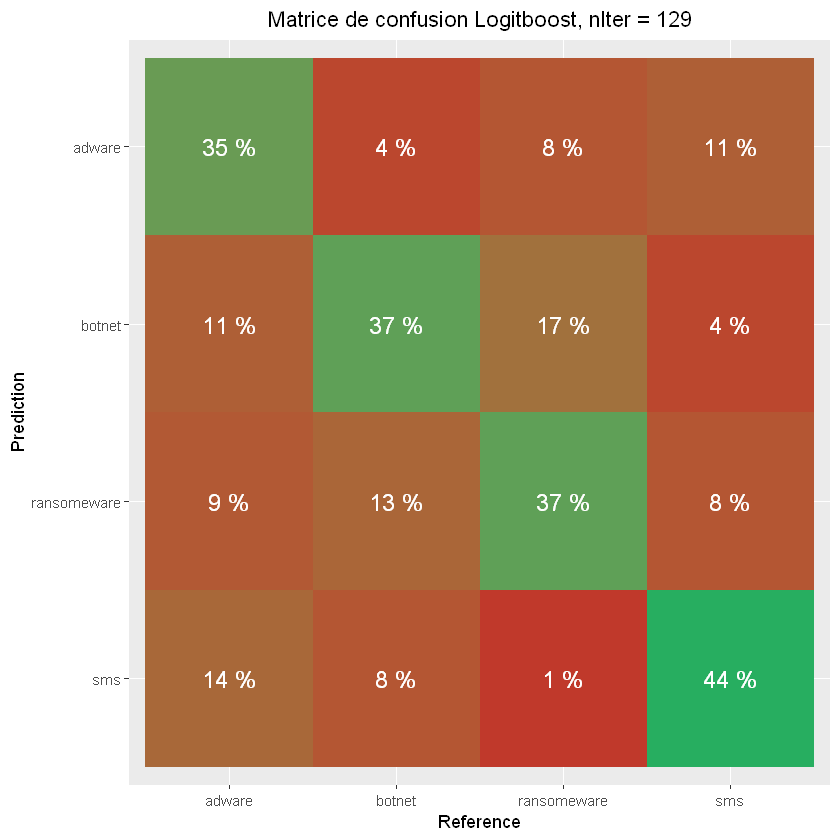

In [52]:
confmatrix(test_lgb$Label, pred_lgb) +
labs(title = "Matrice de confusion Logitboost, nIter = 129")

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


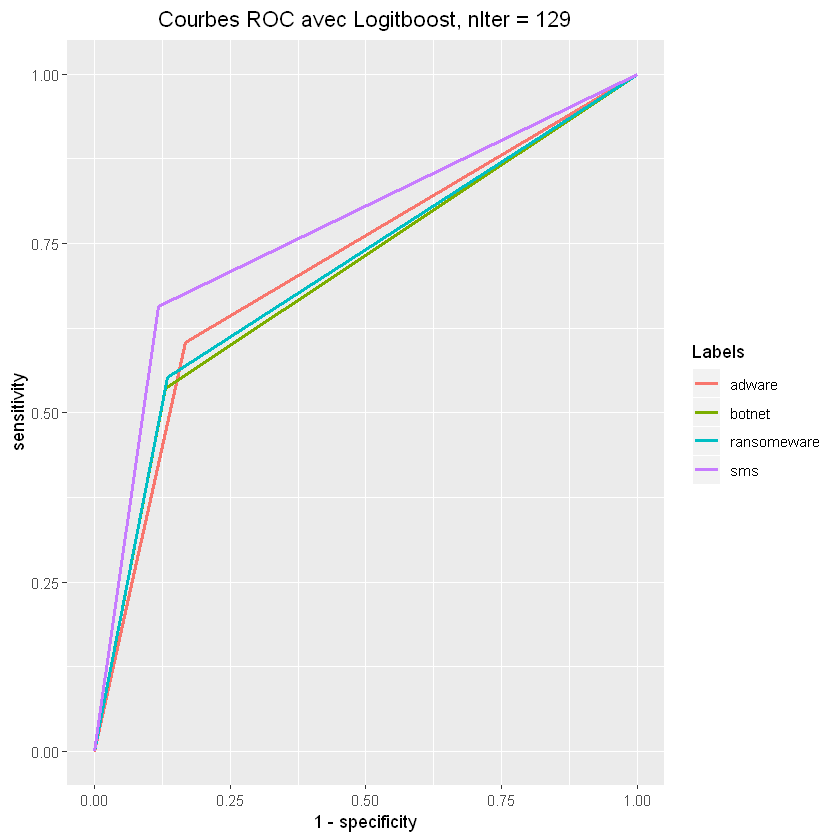

In [53]:
multiroc(test_lgb$Label, pred_lgb) +
labs(title = "Courbes ROC avec Logitboost, nIter = 129")

In [54]:
result <- result %>%
bind_rows(
    (lgb_cv$results %>% 
     filter(nIter == 129)  %>%
     mutate(Model = "LGB") %>% 
     select(Model, AUC, Accuracy)
    )
)

## 4. Gradient boosting

In [55]:
gbm_tune_naive <- data.frame(
    shrinkage = rep(0.1, 21),
    interaction.depth = rep(c(1,3,5), 7),
    n.minobsinnode = rep(10, 21),
    n.trees = c(rep(50, 3), rep(100, 3), rep(500, 3), rep(1000, 3), rep(1500, 3), rep(2500, 3), rep(4000, 3))
)

In [56]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

gbm_cv_naive <- train(
    Label ~ .,
    data = train_set,
    method = "gbm",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = gbm_tune_naive
)

on.exit(stopCluster(cl))

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 53: IP185.176 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3863             nan     0.1000    0.0846
     2        1.3320             nan     0.1000    0.0620
     3        1.2933             nan     0.1000    0.0497
     4        1.2608             nan     0.1000    0.0368
     5        1.2361             nan     0.1000    0.0298
     6        1.2147             nan     0.1000    0.0249
     7        1.1965             nan     0.1000    0.0283
     8        1.1768             nan     0.1000    0.0217
     9        1.1610             nan     0.1000    0.0142
    10        1.1496             nan     0.1000    0.0154
    20        1.0552             nan     0.1000    0.0081
    40        0.9432             nan     0.1000    0.0021
    60        0.8669             nan     0.1000    0.0005
    80        0.8128             nan     0.1000    0.0007
   100        0.7646             nan     0.1000   -0.0017
   120        0.7255             nan     0.1000   -0.0011
   140        

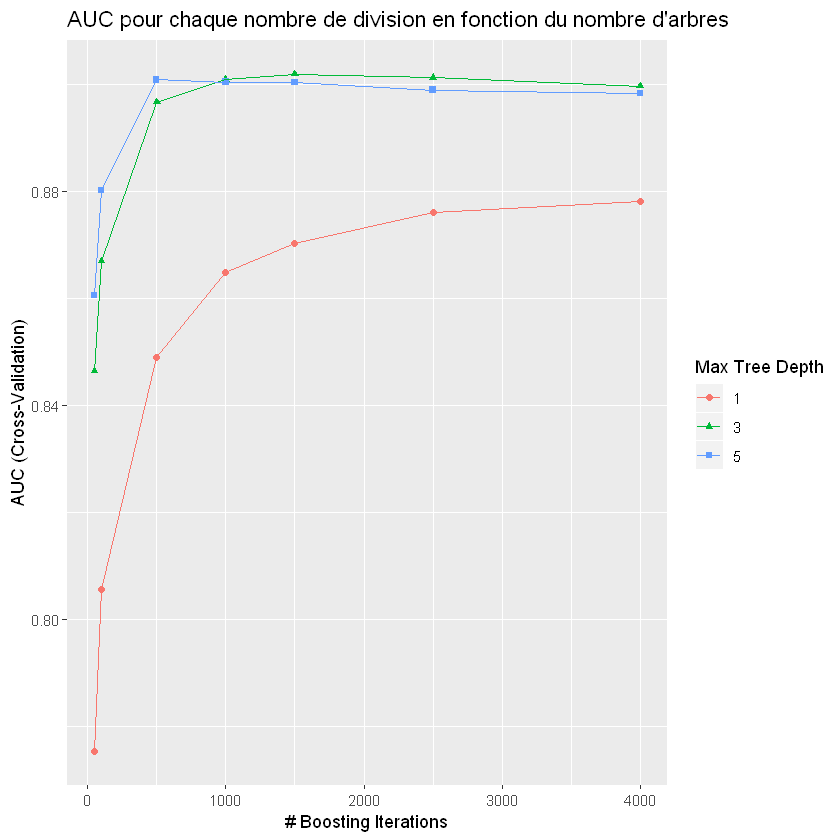

In [57]:
ggplot(gbm_cv_naive) +
labs(title = "AUC pour chaque nombre de division en fonction du nombre d'arbres")

Selecting by rel.inf


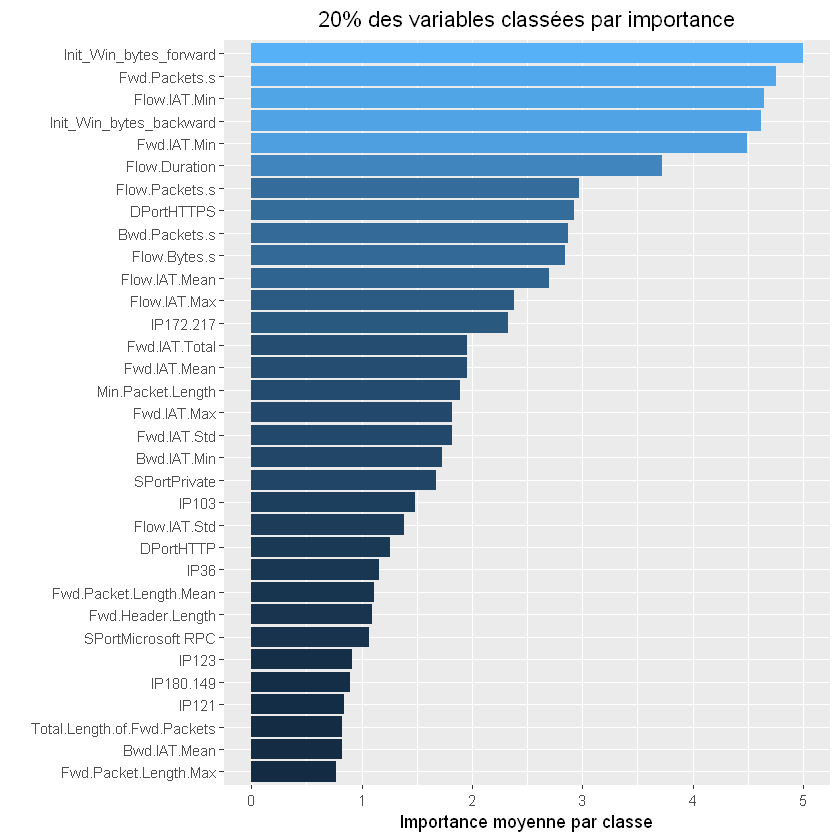

In [102]:
gbm_naive_vars <- summary(gbm_cv_naive$finalModel, plotit = F) %>% as_tibble() %>% 
arrange(rel.inf) %>% mutate(var = factor(var, levels = var)) %>% top_frac(0.20)

ggplot(gbm_naive_vars) + coord_flip() + aes(x = var, y = rel.inf, fill = rel.inf) + geom_bar(stat = "identity") + 
    labs(title = "20% des variables classées par importance", x = "", y = "Importance moyenne par classe") +
    theme(plot.title = element_text(hjust = 0.5)) + guides(fill = F)

### Optimisation

In [59]:
data_gbm <- data %>% 
select(
    Label, DPort, IP,
    any_of(tail(gbm_naive_vars, 13)$var)
) %>% 
mutate(
    IP = factor(if_else(
        as.character(IP) == "172.217",
        as.character(IP), "OtherIP"
    )),
    DPort = factor(if_else(
        DPort == "HTTPS",
        as.character(DPort), "OtherDPort"
    ))
)

In [60]:
dim_quant_gbm <- data_gbm %>% select_if(is.numeric) %>% ncol()
dim_IP_gbm <- length(unique(data_gbm$IP))
dim_DPort_gbm <- length(unique(data_gbm$DPort))
dim_X_gbm <- dim_quant_gbm + dim_IP_gbm-1 + dim_DPort_gbm-1

In [61]:
train_gbm <- split_set(data_gbm)[[1]]
test_gbm <- split_set(data_gbm)[[2]]

In [62]:
gbm_tune <- data.frame(
    shrinkage = rep(0.1, 14),
    interaction.depth = rep(3, 14),
    n.minobsinnode = rep(10, 14),
    n.trees = seq(1100, 2400, by = 100)
)

In [63]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

gbm_cv <- train(
    Label ~ .,
    data = train_gbm,
    method = "gbm",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = gbm_tune
)

on.exit(stopCluster(cl))

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3863             nan     0.1000    0.0817
     2        1.3368             nan     0.1000    0.0568
     3        1.3013             nan     0.1000    0.0408
     4        1.2747             nan     0.1000    0.0314
     5        1.2535             nan     0.1000    0.0242
     6        1.2369             nan     0.1000    0.0186
     7        1.2217             nan     0.1000    0.0257
     8        1.2044             nan     0.1000    0.0180
     9        1.1915             nan     0.1000    0.0142
    10        1.1798             nan     0.1000    0.0108
    20        1.1059             nan     0.1000    0.0026
    40        1.0183             nan     0.1000    0.0013
    60        0.9641             nan     0.1000    0.0007
    80        0.9160             nan     0.1000   -0.0015
   100        0.8742             nan     0.1000   -0.0009
   120        0.8427             nan     0.1000   -0.0005
   140        

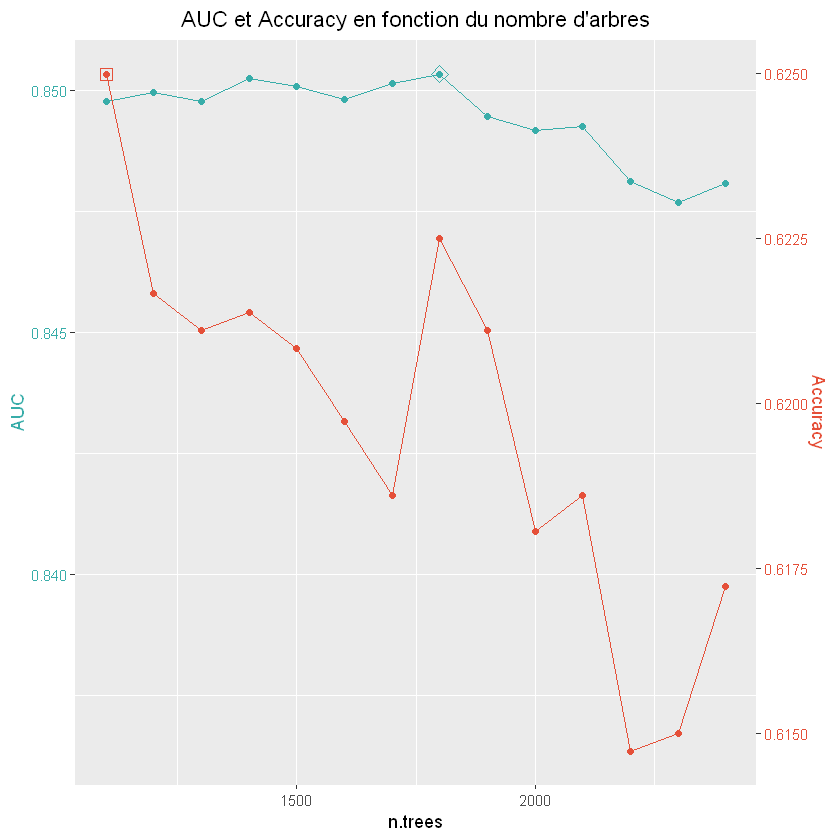

In [64]:
plotmetrics(gbm_cv, "n.trees") +
labs(title = "AUC et Accuracy en fonction du nombre d'arbres")

In [65]:
model_gbm <- gbm_cv$finalModel
pred_gbm <- predict(gbm_cv, newdata = test_gbm)

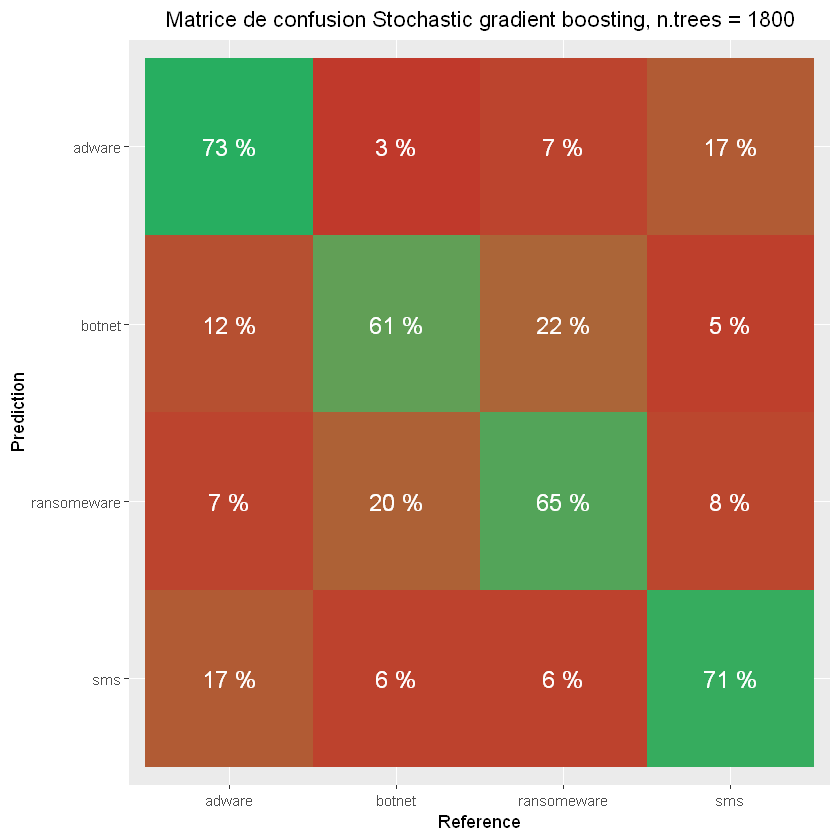

In [66]:
confmatrix(test_gbm$Label, pred_gbm) +
labs(title = "Matrice de confusion Stochastic gradient boosting, n.trees = 1800")

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


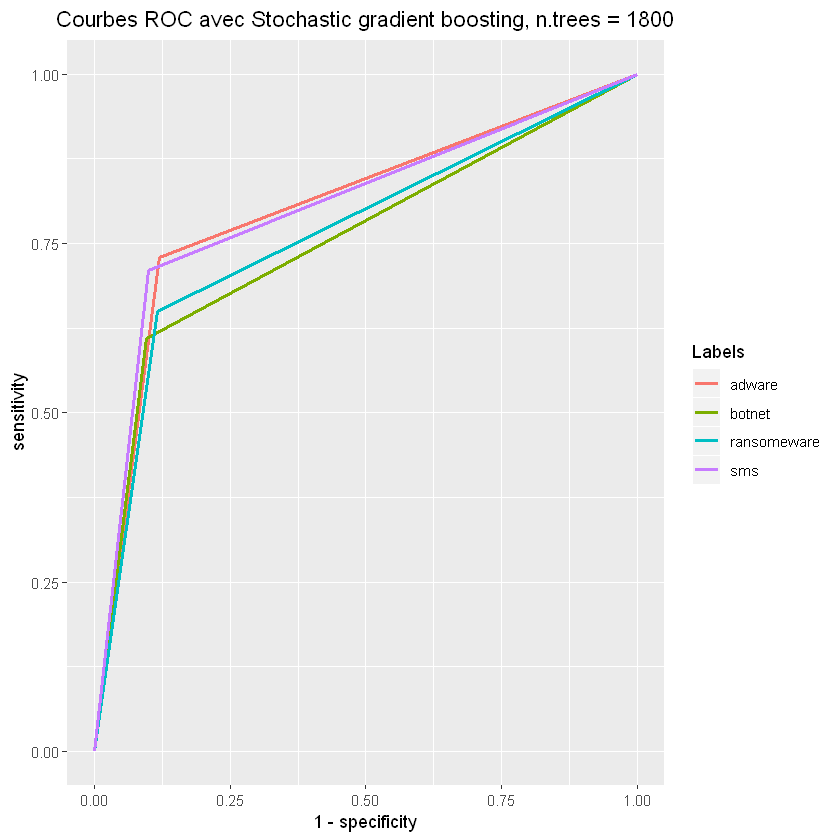

In [67]:
multiroc(test_gbm$Label, pred_gbm) +
labs(title = "Courbes ROC avec Stochastic gradient boosting, n.trees = 1800")

In [68]:
result <- result %>%
bind_rows(
    (gbm_cv$results %>% 
     filter(n.trees == 1800)  %>%
     mutate(Model = "GBM") %>% 
     select(Model, AUC, Accuracy)
    )
)

# IV. Sélection de modèle

## 1. Comparaisons

In [100]:
predicted <- tibble(Y = test_set$Label, KNN = pred_knn, RF = pred_rf, LGB = pred_lgb, GBM = pred_gbm)
plotlist <- vector(mode = "list")
for (label in unique(data$Label)){
    roclist <- vector(mode = "list")
    one_rest <- predicted %>% 
    mutate_all(funs(
        if_else(. == !!label, 1, 0)
    ))
    for (model in c('KNN', 'RF', 'LGB', 'GBM')){
        roclist[[model]] <- roc(one_rest$Y, pull(one_rest, model))
    }
    plotlist[[label]] <- ggroc(roclist, aes = "color", size = 1.2, legacy.axes = TRUE) +
    labs(color = "Models", title = label, x = NULL, y = NULL) + geom_abline() +
    theme(plot.title = element_text(hjust = 0.5, face = "bold"))
}

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


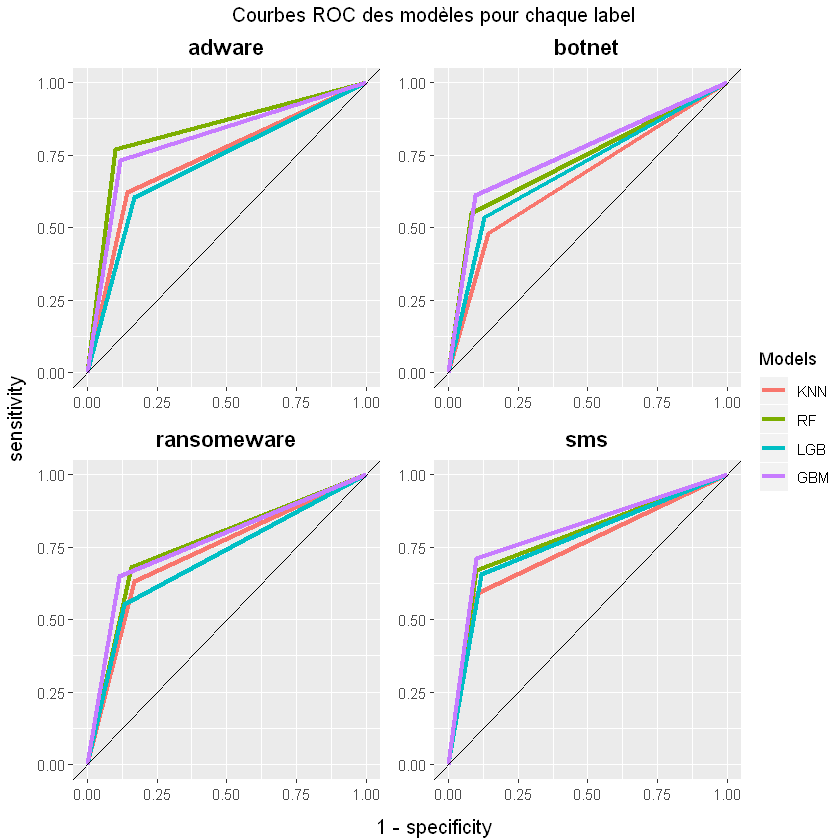

In [101]:
ggarrange(
    plotlist = plotlist,
    ncol = 2, nrow = 2,
    common.legend = T,
    legend = "right"
) %>% 
annotate_figure(
    top = "Courbes ROC des modèles pour chaque label",
    left = "sensitivity",
    bottom = "1 - specificity"
)

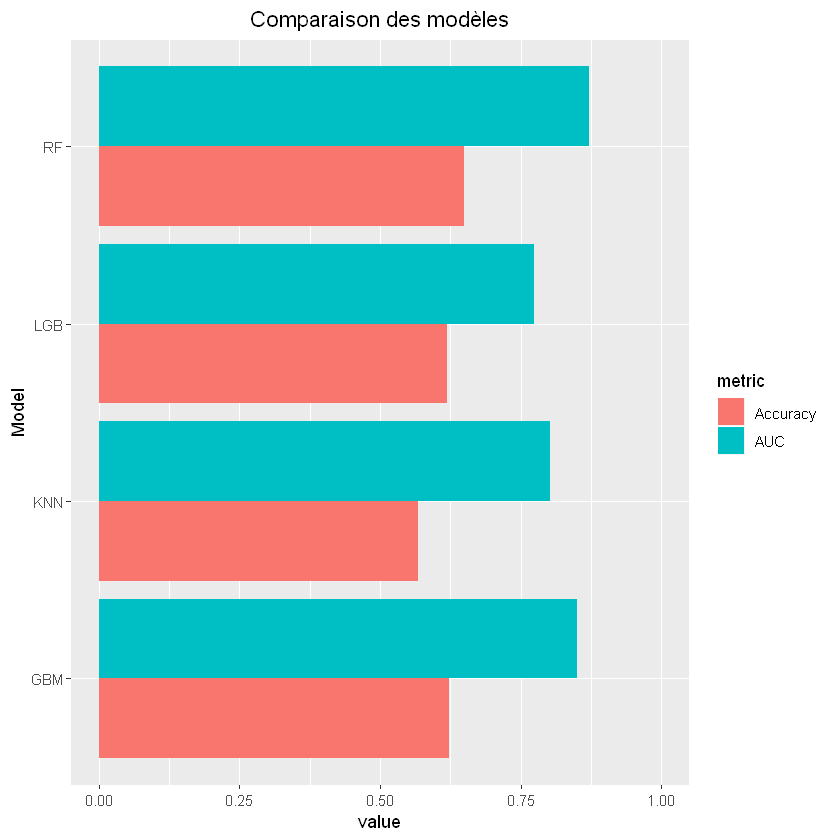

In [71]:
result %>% 
gather(metric, value, -Model) %>% 
ggplot() +
aes(fill = metric, y = value, x = Model) +
geom_bar(position = "dodge", stat = "identity") +
coord_flip(ylim = c(0, 1)) +
labs(title = "Comparaison des modèles") +
theme(plot.title = element_text(hjust = 0.5))